## Training
A template Jupyter notebook to further train models.
Data is given in compressed form and extracted for training.

In [17]:
import os
import errno
import random
import shutil
import zipfile
import importlib

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
#from deepcell.training import train_model_sample
import deepcell.training
import deepcell.image_generators

In [2]:
importlib.reload(deepcell.training)
importlib.reload(deepcell.image_generators)

<module 'deepcell.image_generators' from '/usr/local/lib/python3.5/dist-packages/deepcell/image_generators.py'>

In [12]:
RESIZE = False
RESHAPE_SIZE = 256

# filepath constants
ROOT_DIR = "/data/output"
DATA_DIR = "/data/contour_data/"
MODEL_DIR = "/data/models"
NPZ_DIR = "/data/npz_data"
LOG_DIR = "/data/logs"
DATA_FILE = "Point1_12_18_23_20190606_output_3_class"
RAW_PATH = os.path.join(DATA_DIR, DATA_FILE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = keras.backend.image_data_format() == "channels_first"
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

N_FRAMES = 5

# for d in (NPZ_DIR, MODEL_DIR, LOG_DIR, DATA_DIR):
#     if not d.startswith("/"):
#         continue  # not a local directory, no need to create it
#     try:
#         os.makedirs(d)
#     except OSError as exc:
#         if exc.errno != errno.EEXIST:
#             raise

In [14]:
make_training_data(
    channel_names=['border_3_class.tiff', 'border_4_class_1.tiff', 'border_4_class_2.tiff'],
    #channel_names=['border_3_class.tiff', 'interior_3_class.tiff'],
    file_name_save=os.path.join(NPZ_DIR, "Point1_12_18_23_20190606_output_all_border"),
    dimensionality=2,
    annotation_direc="annotated",
    annotation_name='Nuclear_Interior_Border_Mask_Label',
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    training_direcs=None,
    raw_image_direc="raw",
    direc_name=os.path.join(DATA_DIR, DATA_FILE)
)

#assert os.path.isfile(os.path.join(NPZ_DIR, "Point1_12_18_3X_interior_border_border") + ".npz")

In [16]:
reshape_size=RESHAPE_SIZE if RESIZE else None
print(reshape_size)

None


In [31]:
# create folder for this set of experiments
experiment_folder = "20190621_postprocessing"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [32]:
npz_name = "Point1_12_18_20190606_output"
MODEL_NAME = npz_name + 'first_try'
n_epoch = 30

In [33]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, npz_name + ".npz"))

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])

# Set up other training parameters
batch_size = 32
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (3, 1024, 1024, 3) & y.shape: (3, 1024, 1024, 1)


In [34]:
# Instantiate the model
model = bn_feature_net_2D(
    n_features=3,
    n_dense_filters=128,
    n_channels=X.shape[CHANNEL_AXIS],
    receptive_field=61,
    reg=1e-05,
    norm_method="std",
    input_shape=input_shape,
    n_conv_filters=64,
)

In [22]:
# load previously saved model
# model.load_weights('/data/models/Point1_12_18_3X_interior_callback_test.h5')

In [35]:
print(MODEL_NAME)

Point1_12_18_20190606_outputfirst_try


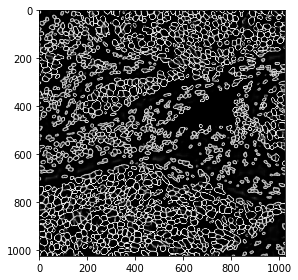

In [38]:
import skimage.io as io
io.imshow(X[0, :, :, 0])


In [ ]:
# Train the model
model = deepcell.training.train_model_sample(
    max_class_samples=300000,
    dataset=os.path.join(NPZ_DIR, npz_name + ".npz"),
    direc_data=NPZ_DIR,
    batch_size=batch_size,
    rotation_range=180,
    balance_classes=True,
    model=model,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    transform="deepcell_old",
    log_dir=LOG_DIR,
    dilation_radius=1,
    shear=False,
    lr_sched=lr_sched,
    window_size=(30, 30),
    flip=True,
    optimizer=optimizer,
    expt="sample_deepcell",
    model_name=MODEL_NAME,
    val_monitor=False,
    save_period=5,
    class_weights=None
    #class_weights={0:3, 1:1, 2:1}
)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0}
X_train shape: (3, 1024, 1024, 3)
y_train shape: (3, 1024, 1024, 1)
Output Shape: (None, 3)
Number of Classes: 3
Training on 1 GPUs
Dilation raidus is set to 1
the max_class_samples per image is 100000
analyzing image 0
the least represented class has 122478 examples
max_class_samples is less than the smalleset class, downsampling all classes
analyzing class 0
downsampling from 122478 examples per class
analyzing class 1
downsampling from 265307 examples per class
analyzing class 2
downsampling from 539584 examples per class
analyzing image 1
the least represented class has 93322 examples
analyzing class 0
downsampling from 93322 examples per class
analyzing class 1
downsampling from 369638 examples per class
analyzing class 2
downsampling from 464409 examples per class
analyzing image 2
the least represented class has 101744 examples
max_class_samples is less than the smalleset class, downsampling all clas